In [65]:
import shap
import sys
import importlib
sys.path.append('/home/robbe/IM2DeepMulti')
sys.path.append('/home/robbe/IM2DeepMulti/IM2DeepMulti')
from datetime import datetime
from IM2DeepMulti.models import IM2DeepMultiTransferWithAttention, IM2DeepMultiTransfer
import IM2DeepMulti.utils
importlib.reload(IM2DeepMulti)

import numpy as np
import pickle
from torch.utils.data import DataLoader, TensorDataset


# Load model

In [66]:
# Current best model
config = {
    "name": "BestPearsonBestModel",
    "time": datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    "batch_size": 32,
    "learning_rate": 0.0000885185503354955,
    "diversity_weight": 1.2631492541307987,    # Should be high when using FlexibleLoss (4.2), much lower when using FlexibleLossSorted (1)
    "L1_alpha": 0.00000043707211872154, #0.00003 for FlexibleLoss, 0.02 for FlexibleLossSorted
    "epochs": 300,
    "delta": 0,
    "device": "1",
    "Use_best_model": 1,
    "Add_branch_layer": 0,
    'BranchSize': 28, #64 seems to be the best
    'Loss_type': 'FlexibleLoss',
    'Use_attention_output': 1,
    'Use_attention_concat': 1,
}

In [67]:
import torch
ckpt = torch.load('/home/robbe/IM2DeepMulti/checkpoints/BestModelAdaptedToNewArch.ckpt')

In [68]:
criterion = IM2DeepMulti.utils.FlexibleLoss(config['diversity_weight'])
best_model = IM2DeepMultiTransferWithAttention.load_from_checkpoint('/home/robbe/IM2DeepMulti/checkpoints/BestModelAdaptedToNewArch.ckpt', config=config, criterion=criterion)


1335
480
20
6
1841


# Prepare test data

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
# Test
ccs_df_test = pickle.load(open('/home/robbe/IM2DeepMulti/data/ccs_df_test_OnlyMoreMultimodals.pkl', 'rb'))
Test_AtomEnc = pickle.load(open("/home/robbe/IM2DeepMulti/data/X_test_AtomEnc-OnlyMoreMultimodals.pickle", "rb"))
Test_Globals = pickle.load(
    open("/home/robbe/IM2DeepMulti/data/X_test_GlobalFeatures-OnlyMoreMultimodals.pickle", "rb")
)
Test_DiAminoAtomEnc = pickle.load(open('/home/robbe/IM2DeepMulti/data/X_test_DiAminoAtomEnc-OnlyMoreMultimodals.pickle', 'rb'))
Test_OneHot = pickle.load(open('/home/robbe/IM2DeepMulti/data/X_test_OneHot-OnlyMoreMultimodals.pickle', 'rb'))
y_test = pickle.load(open('/home/robbe/IM2DeepMulti/data/y_test-OnlyMoreMultimodals.pickle', 'rb'))

y_test = np.vstack(y_test)
print(y_test.shape)
Test_AtomEnc = torch.tensor(Test_AtomEnc, dtype=torch.float32)
Test_Globals = torch.tensor(Test_Globals, dtype=torch.float32)
Test_DiAminoAtomEnc = torch.tensor(Test_DiAminoAtomEnc, dtype=torch.float32)
Test_OneHot = torch.tensor(Test_OneHot, dtype=torch.float32)
y_test = torch.tensor(y_test)
test_dataset = TensorDataset(Test_AtomEnc, Test_DiAminoAtomEnc, Test_Globals, Test_OneHot, y_test)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=16)


(881, 2)


In [71]:
best_model.eval()
background_data = torch.utils.data.Subset(test_dataset, indices=np.arange(0, 400))
background_loader = DataLoader(background_data, batch_size=10, shuffle=False)
test_data = torch.utils.data.Subset(test_dataset, indices=np.arange(400, 800))
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


In [72]:
background_samples = next(iter(background_loader))
background_tensor = [t.to(device) for t in background_samples[:-1]]
test_samples = next(iter(test_loader))
test_tensor = [t.to(device) for t in test_samples[:-1]]
print("Background tensor types:", [type(t) for t in background_tensor[:-1]])
print("Test tensor types:", [type(t) for t in test_tensor[:-1]])
e = shap.DeepExplainer(best_model, background_tensor)

Background tensor types: [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Test tensor types: [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]


In [73]:
shap_values = e.shap_values(test_tensor, check_additivity=False)

/home/robbe/.pyenv/versions/3.10.13/envs/multioutput/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [74]:
shap_values[3].shape

(10, 60, 20, 2)

In [75]:
atomenc_output_1 = shap_values[0][:,:,:,0].mean(axis=0)
atomenc_output_2 = shap_values[0][:,:,:,1].mean(axis=0)
diatomenc_output_1 = shap_values[1][:,:,:,0].mean(axis=0)
diatomenc_output_2 = shap_values[1][:,:,:,1].mean(axis=0)
global_output_1 = shap_values[2][:,:,0].mean(axis=0)
global_output_2 = shap_values[2][:,:,1].mean(axis=0)
onehot_output_1 = shap_values[3][:,:,:,0].mean(axis=0)
onehot_output_2 = shap_values[3][:,:,:,1].mean(axis=0)


In [76]:
atomenc_output_1.shape

(60, 6)

# Atom Enc

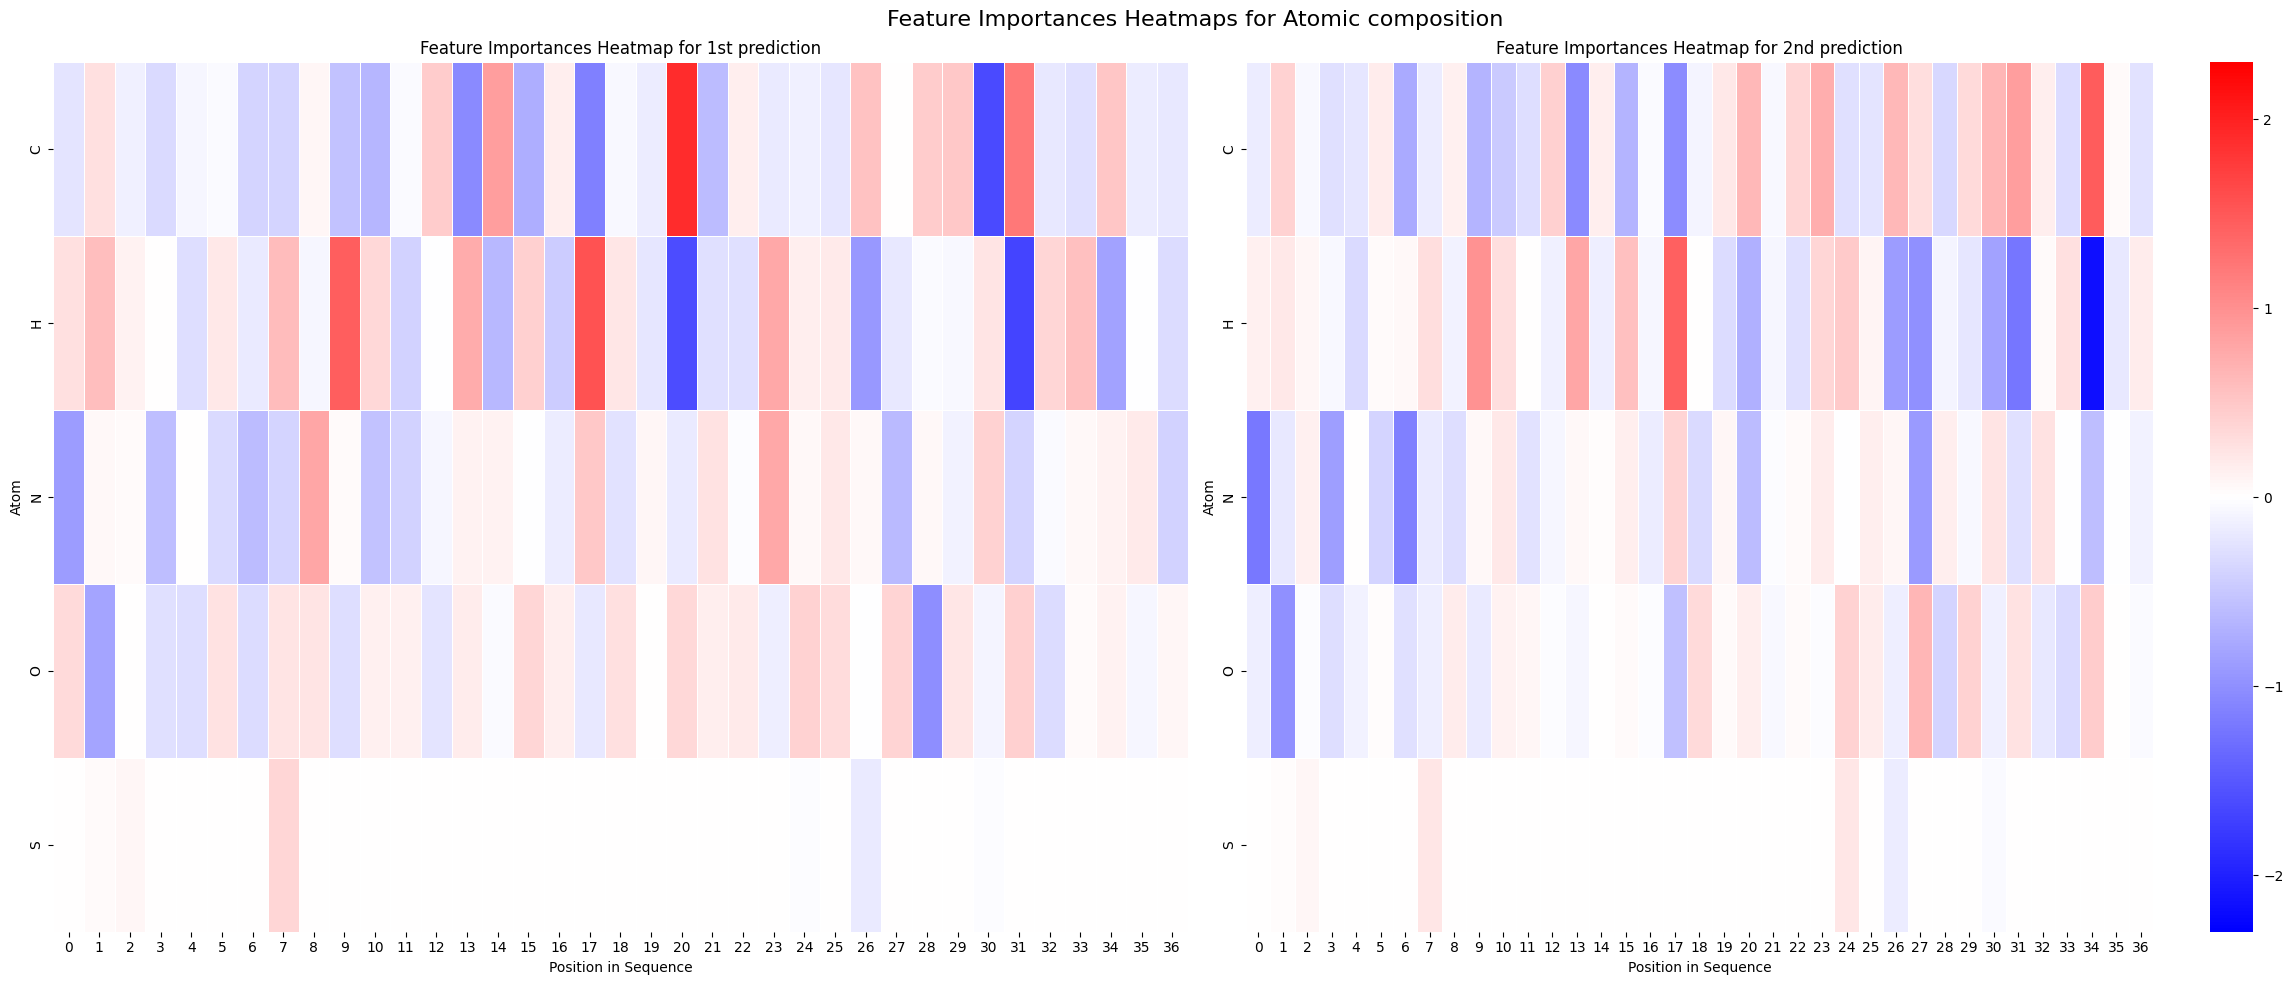

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Everything past (36, 5) is 0, so we can remove it
atomenc_output_1 = atomenc_output_1[:37, :5]
atomenc_output_2 = atomenc_output_2[:37, :5]

# Setup for side-by-side plotting
fig, axs = plt.subplots(ncols=2, figsize=(24, 10))  # Create two columns for subplots

# Use spectral colormap
cmap = sns.color_palette("bwr", as_cmap=True)


vmin = min(-2.3,2.3)
vmax = max(-2.3,2.3)

# Transpose the SHAP values matrices to invert axes and mask zeros
shap_values_output1_masked = np.ma.masked_where(atomenc_output_1 == 0., atomenc_output_1)
shap_values_output2_masked = np.ma.masked_where(atomenc_output_2 == 0., atomenc_output_2)

# Create a heatmap for the first output
sns.heatmap(shap_values_output1_masked.T, ax=axs[0], annot=False, cmap=cmap, fmt=".2f", linewidths=.5, cbar=False, vmin=vmin, vmax=vmax)
axs[0].set_title('Feature Importances Heatmap for 1st prediction')
axs[0].set_xlabel('Position in Sequence')
axs[0].set_ylabel('Atom')
axs[0].set_yticklabels(['C', 'H', 'N', 'O', 'S'])

# Create a heatmap for the second output
sns.heatmap(shap_values_output2_masked.T, ax=axs[1], annot=False, cmap=cmap, fmt=".2f", linewidths=.5, cbar=True, vmin=vmin, vmax=vmax)
axs[1].set_title('Feature Importances Heatmap for 2nd prediction')
axs[1].set_xlabel('Position in Sequence')
axs[1].set_ylabel('Atom')
axs[1].set_yticklabels(['C', 'H', 'N', 'O', 'S'])

plt.suptitle('Feature Importances Heatmaps for Atomic composition', fontsize=16)
plt.tight_layout()  # Adjust layout to not overlap
plt.show()


# DiAA Atom Enc

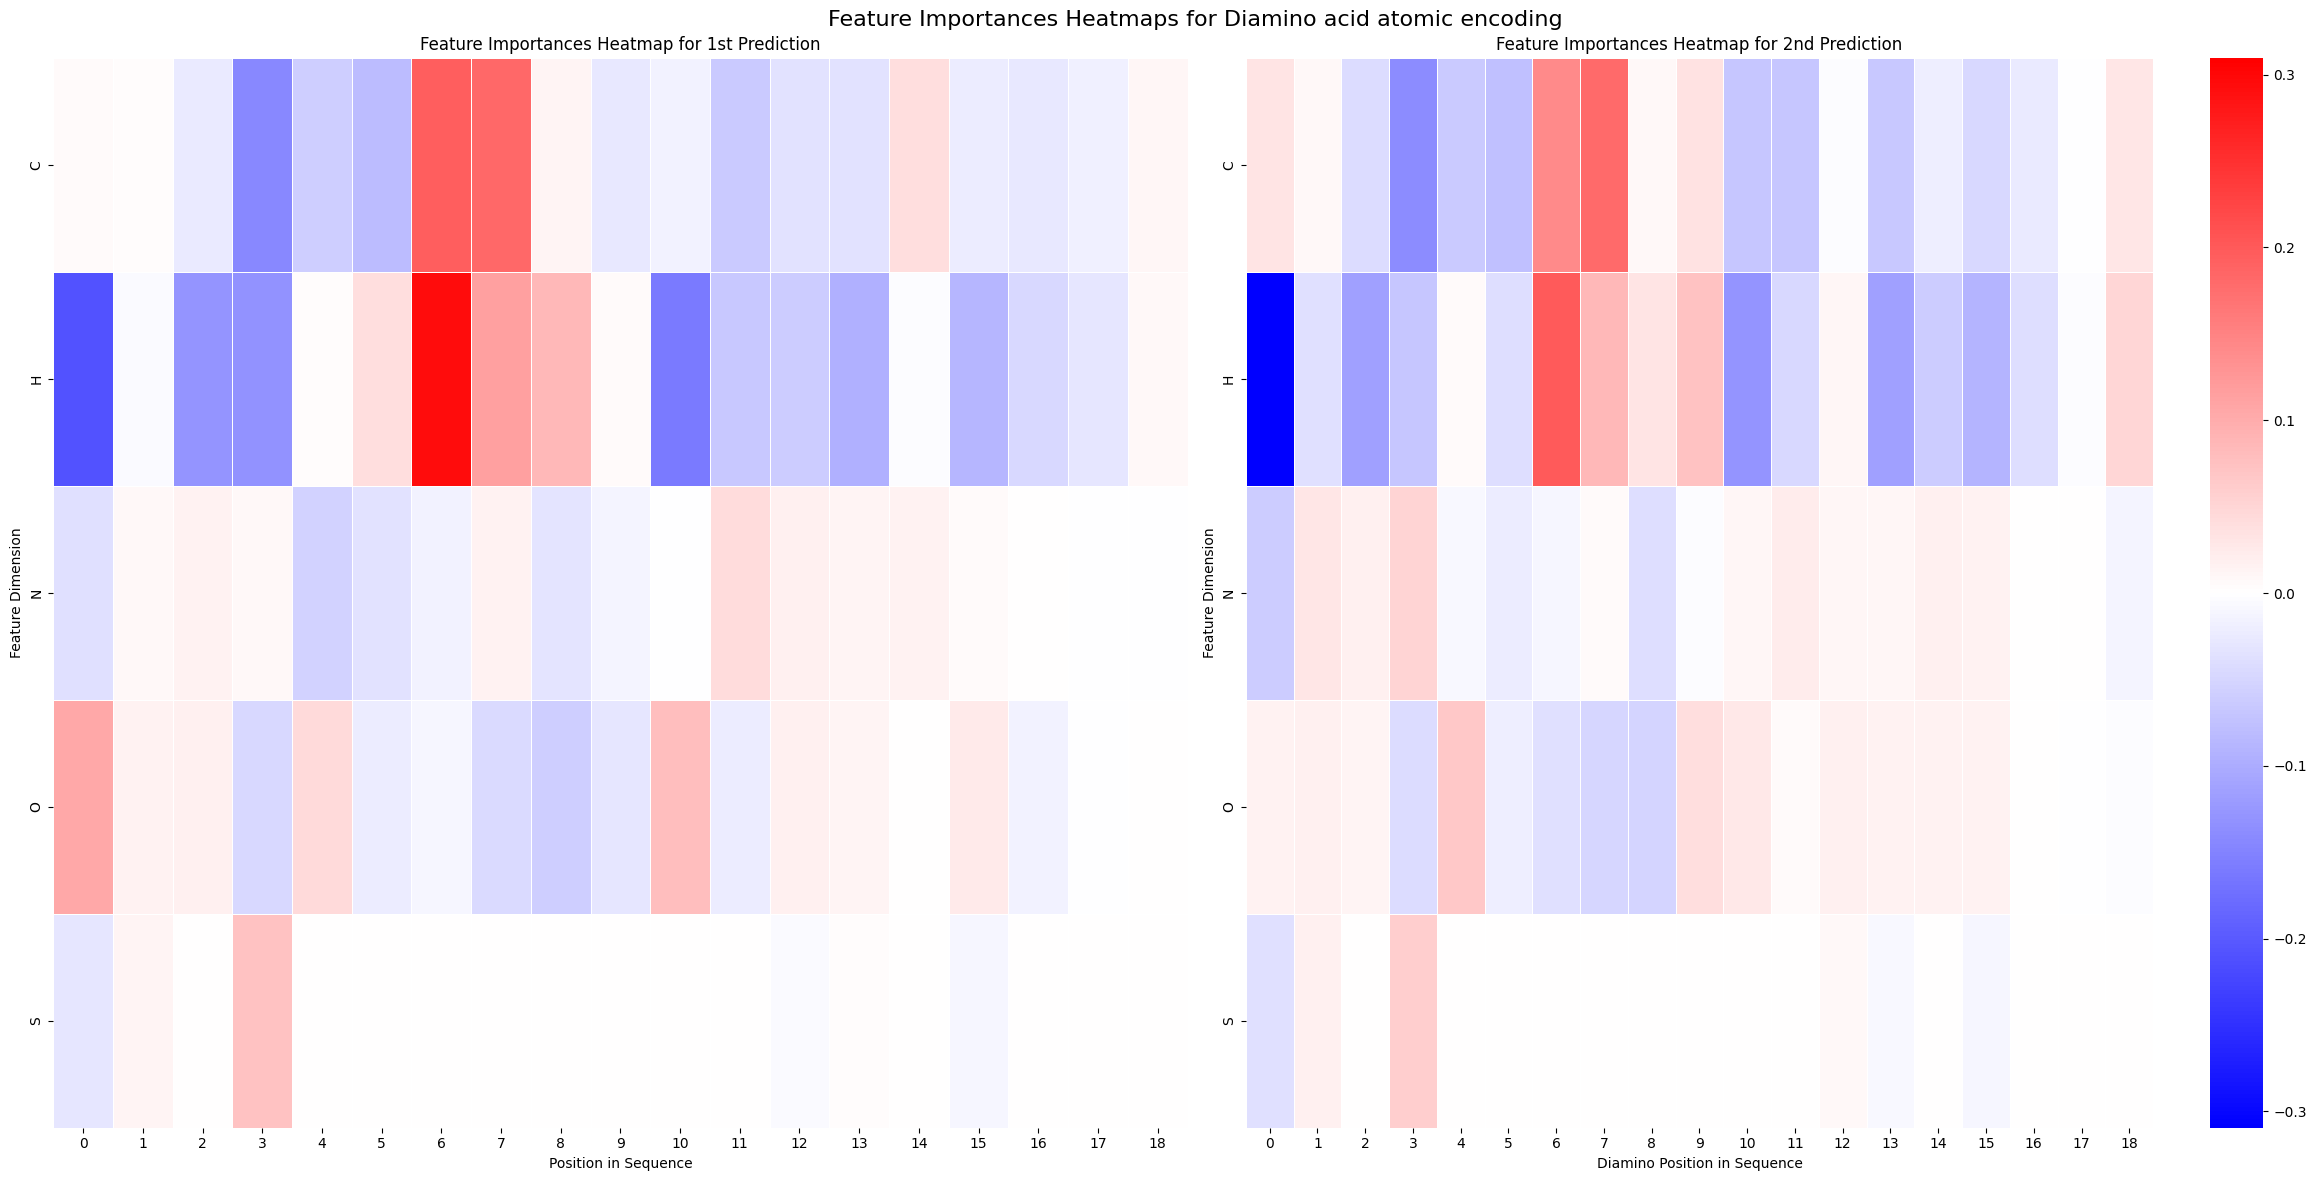

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Everything past (19, 5) is 0, so we can remove it
diatomenc_output_1 = diatomenc_output_1[:19, :5]
diatomenc_output_2 = diatomenc_output_2[:19, :5]

# Setup for side-by-side plotting
fig, axs = plt.subplots(ncols=2, figsize=(24, 12))  # Adjust size as needed

# Use a blue-red colormap which is good for diverging data
cmap = sns.color_palette("bwr", as_cmap=True)

# Define vmin and vmax for color scaling based on the maximum absolute value in both matrices
vmin, vmax = -np.max(np.abs([diatomenc_output_1, diatomenc_output_2])), np.max(np.abs([diatomenc_output_1, diatomenc_output_2]))

# Mask zeros for visualization clarity
shap_values_output1_masked = np.ma.masked_where(diatomenc_output_1 == 0, diatomenc_output_1)
shap_values_output2_masked = np.ma.masked_where(diatomenc_output_2 == 0, diatomenc_output_2)

# Create a heatmap for the first output
sns.heatmap(shap_values_output1_masked.T, ax=axs[0], annot=False, cmap=cmap, fmt=".2f", linewidths=.5, cbar=False, vmin=vmin, vmax=vmax)
axs[0].set_title('Feature Importances Heatmap for 1st Prediction')
axs[0].set_xlabel('Position in Sequence')
axs[0].set_ylabel('Feature Dimension')
# Update yticklabels if you have specific labels for the dimensions
axs[0].set_yticklabels(['C', 'H', 'N', 'O', 'S'])

# Create a heatmap for the second output
sns.heatmap(shap_values_output2_masked.T, ax=axs[1], annot=False, cmap=cmap, fmt=".2f", linewidths=.5, cbar=True, vmin=vmin, vmax=vmax)
axs[1].set_title('Feature Importances Heatmap for 2nd Prediction')
axs[1].set_xlabel('Diamino Position in Sequence')
axs[1].set_ylabel('Feature Dimension')
axs[1].set_yticklabels(['C', 'H', 'N', 'O', 'S'])

plt.suptitle('Feature Importances Heatmaps for Diamino acid atomic encoding', fontsize=16)
plt.tight_layout()  # Adjust layout to not overlap
plt.show()


# Global feats

In [79]:
global_output_1.shape

(60,)

In [80]:
# C_comp, H_comp, N_comp, O_comp,
#S_comp, P_comp, length, Rel_H presence,
#Rel_Bulky presence, Rel_Acid presence, Rel_KR_presence, charge, 6 x 8 atom counts of first four and last four AA
global_feature_list = [
    'SumC',
    'SumH',
    'SumN',
    'SumO',
    'SumS',
    'SumP',
    'SeqLen',
    'Rel_H',
    'Rel_Bulky',
    'Rel_Acid',
    'Rel_KR',
    'Charge',
    'SumC1',
    'SumH1',
    'SumN1',
    'SumO1',
    'SumS1',
    'SumP1',
    'SumC2',
    'SumH2',
    'SumN2',
    'SumO2',
    'SumS2',
    'SumP2',
    'SumC3',
    'SumH3',
    'SumN3',
    'SumO3',
    'SumS3',
    'SumP3',
    'SumC4',
    'SumH4',
    'SumN4',
    'SumO4',
    'SumS4',
    'SumP4',
    'SumC-4',
    'SumH-4',
    'SumN-4',
    'SumO-4',
    'SumS-4',
    'SumP-4',
    'SumC-3',
    'SumH-3',
    'SumN-3',
    'SumO-3',
    'SumS-3',
    'SumP-3',
    'SumC-2',
    'SumH-2',
    'SumN-2',
    'SumO-2',
    'SumS-2',
    'SumP-2',
    'SumC-1',
    'SumH-1',
    'SumN-1',
    'SumO-1',
    'SumS-1',
    'SumP-1',
]

In [81]:
len(global_feature_list)

60

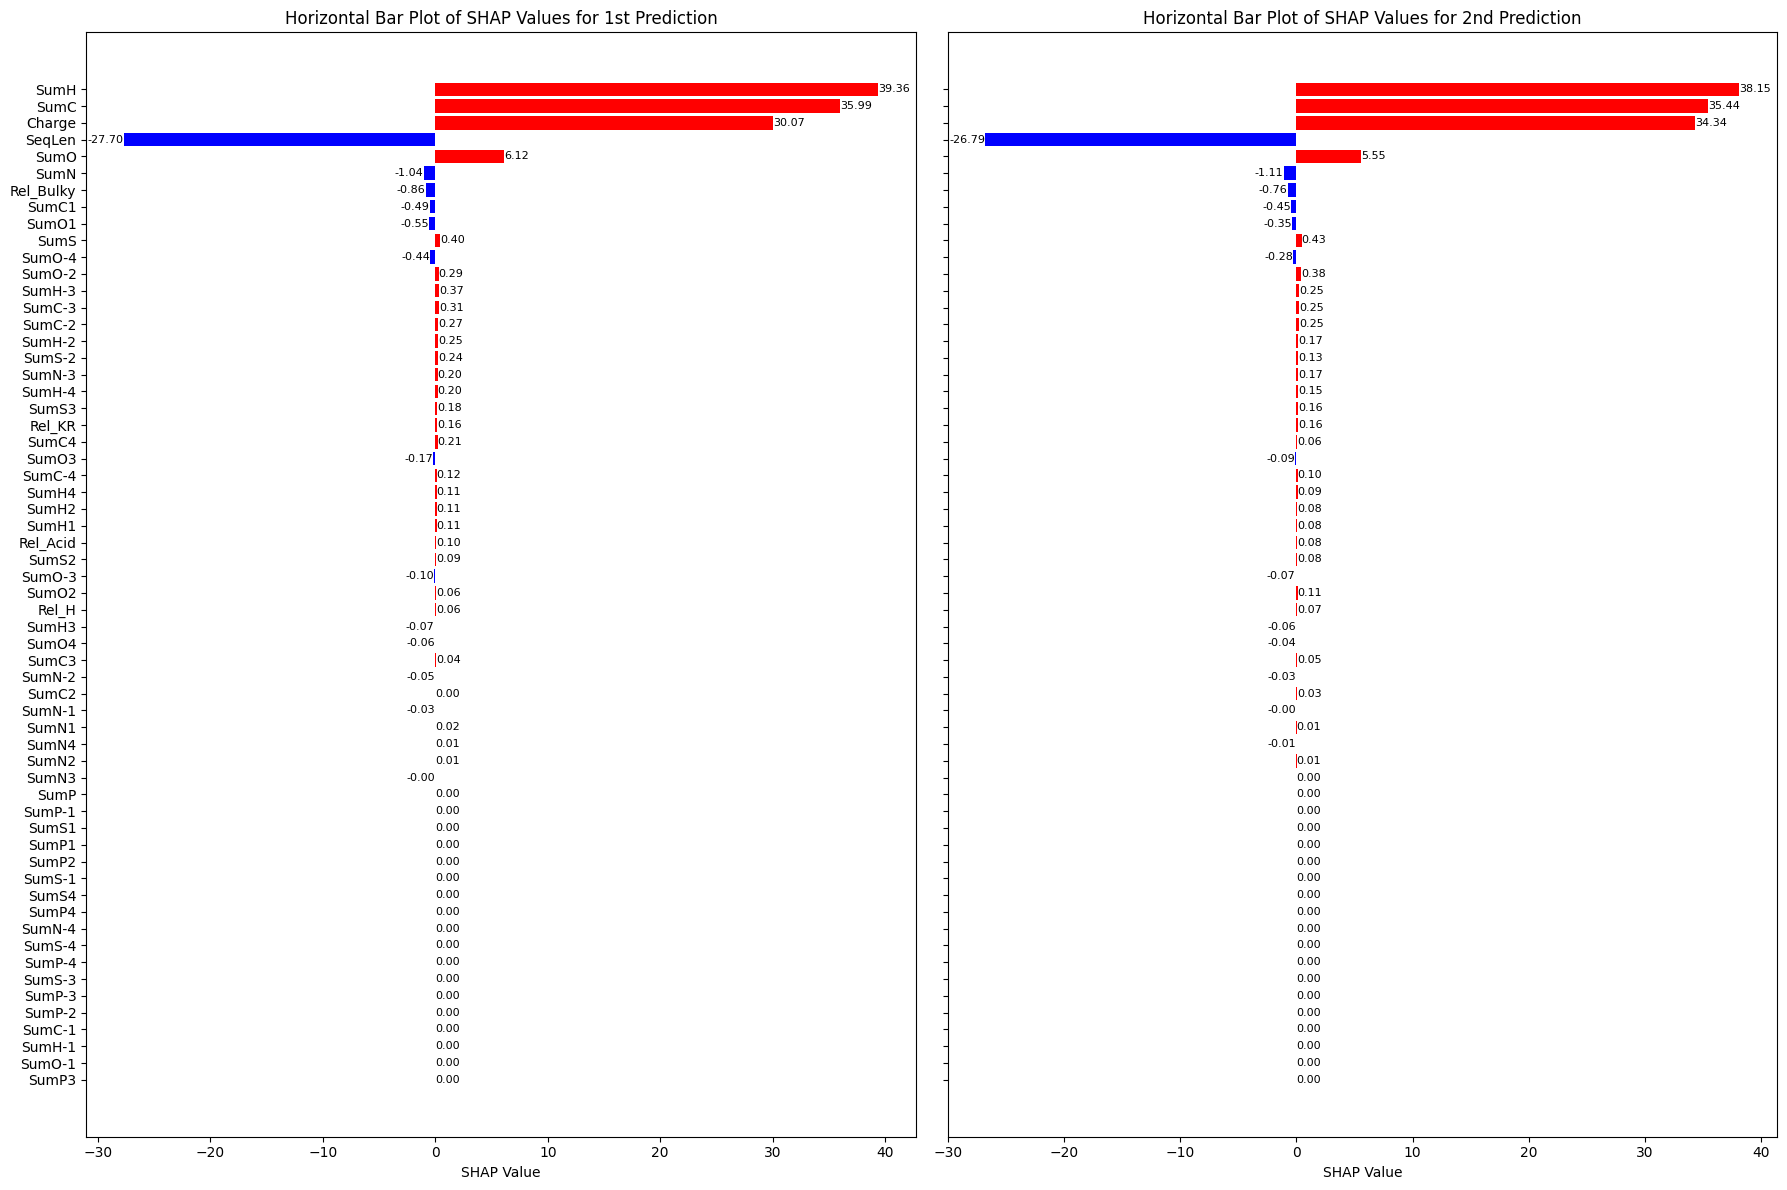

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Generate labels for the features
features = global_feature_list

def create_bar_plot(shap_values, title, ax, feature_order):
    # Use the pre-determined feature order
    sorted_features = [features[i] for i in feature_order]
    sorted_values = shap_values[feature_order]

    # Assign colors based on the value being positive or negative
    colors = ['red' if x > 0 else 'blue' for x in sorted_values]

    # Creating the bar plot
    bars = ax.barh(sorted_features, sorted_values, color=colors)
    ax.set_title(title)
    ax.set_xlabel('SHAP Value')
    ax.invert_yaxis()  # Invert y-axis to align both plots with the same order from top to bottom

    # Annotate bars with the SHAP values
    for bar, value in zip(bars, sorted_values):
        ax.text(value, bar.get_y() + bar.get_height()/2, '%.2f' % value,
                va='center', ha='right' if value < 0 else 'left', color='black', fontsize=8)

# Determine a uniform order for the features; sort by the absolute values of the combined outputs
combined_shap = np.abs(global_output_1) + np.abs(global_output_2)
feature_order = np.argsort(combined_shap)

# Setup plots next to each other
fig, axs = plt.subplots(ncols=2, figsize=(18, 12), sharey=True)

# Generate horizontal bar plots
create_bar_plot(global_output_1, 'Horizontal Bar Plot of SHAP Values for 1st Prediction', axs[0], feature_order)
create_bar_plot(global_output_2, 'Horizontal Bar Plot of SHAP Values for 2nd Prediction', axs[1], feature_order)

plt.tight_layout()
plt.show()



# OneHot

In [83]:
onehot_output_1.shape

(60, 20)

In [84]:
aa_list = ["K", "R", "P","T","N","A","Q","V","S","G","I","L","C","M","H","F","Y","W","E","D"]

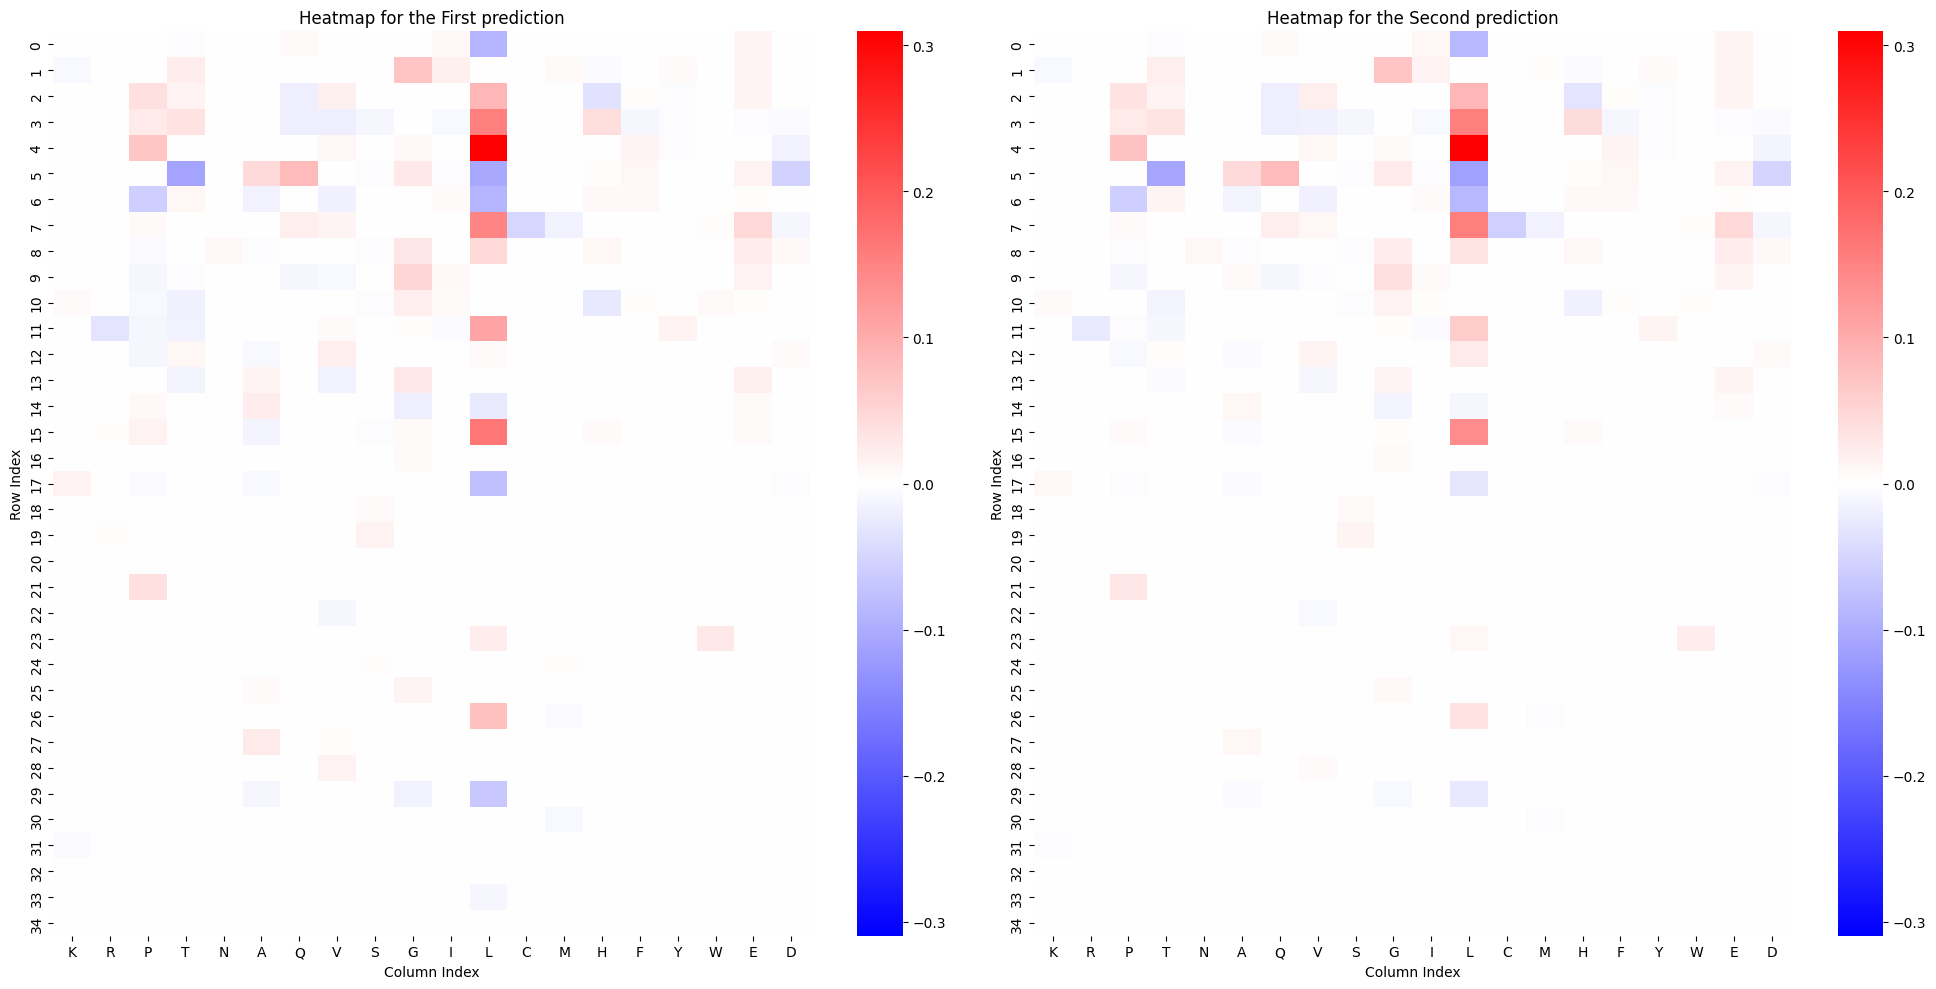

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Everything past position 34 is 0, so we can remove it
onehot_output_1 = onehot_output_1[:35]
onehot_output_2 = onehot_output_2[:35]

# Assuming `data1` and `data2` are your numpy arrays of shape (60, 20) for the first and second outputs
data1 = onehot_output_1  # Replace with your actual data array for the first output
data2 = onehot_output_2  # Replace with your actual data array for the second output

cmap = sns.color_palette("bwr", as_cmap=True)
vmin, vmax = -np.max(np.abs([diatomenc_output_1, diatomenc_output_2])), np.max(np.abs([diatomenc_output_1, diatomenc_output_2]))

# Create a figure and a set of subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))  # Adjust size to your liking

# Heatmap for the first data set
sns.heatmap(data1, ax=axs[0], cmap=cmap, cbar=True, vmin=vmin, vmax=vmax)
axs[0].set_title('Heatmap for the First prediction')
axs[0].set_xlabel('Column Index')
axs[0].set_ylabel('Row Index')
axs[0].set_xticklabels(aa_list)

# Heatmap for the second data set
sns.heatmap(data2, ax=axs[1], cmap=cmap, cbar=True, vmin=vmin, vmax=vmax)
axs[1].set_title('Heatmap for the Second prediction')
axs[1].set_xlabel('Column Index')
axs[1].set_ylabel('Row Index')
axs[1].set_xticklabels(aa_list)

plt.tight_layout()  # Adjust layout to fit everything properly
plt.show()


In [86]:
# Calculate the mean SHAP values for each amino acid across all positions
amino_acids_mean1 = np.mean(onehot_output_1, axis=0)
amino_acids_mean2 = np.mean(onehot_output_2, axis=0)

# Amino acid labels (You can replace these with actual amino acid names)
amino_acids = aa_list

/tmp/ipykernel_1737335/1669905856.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(amino_acids, rotation=45, ha='right')
/tmp/ipykernel_1737335/1669905856.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(amino_acids, rotation=45, ha='right')


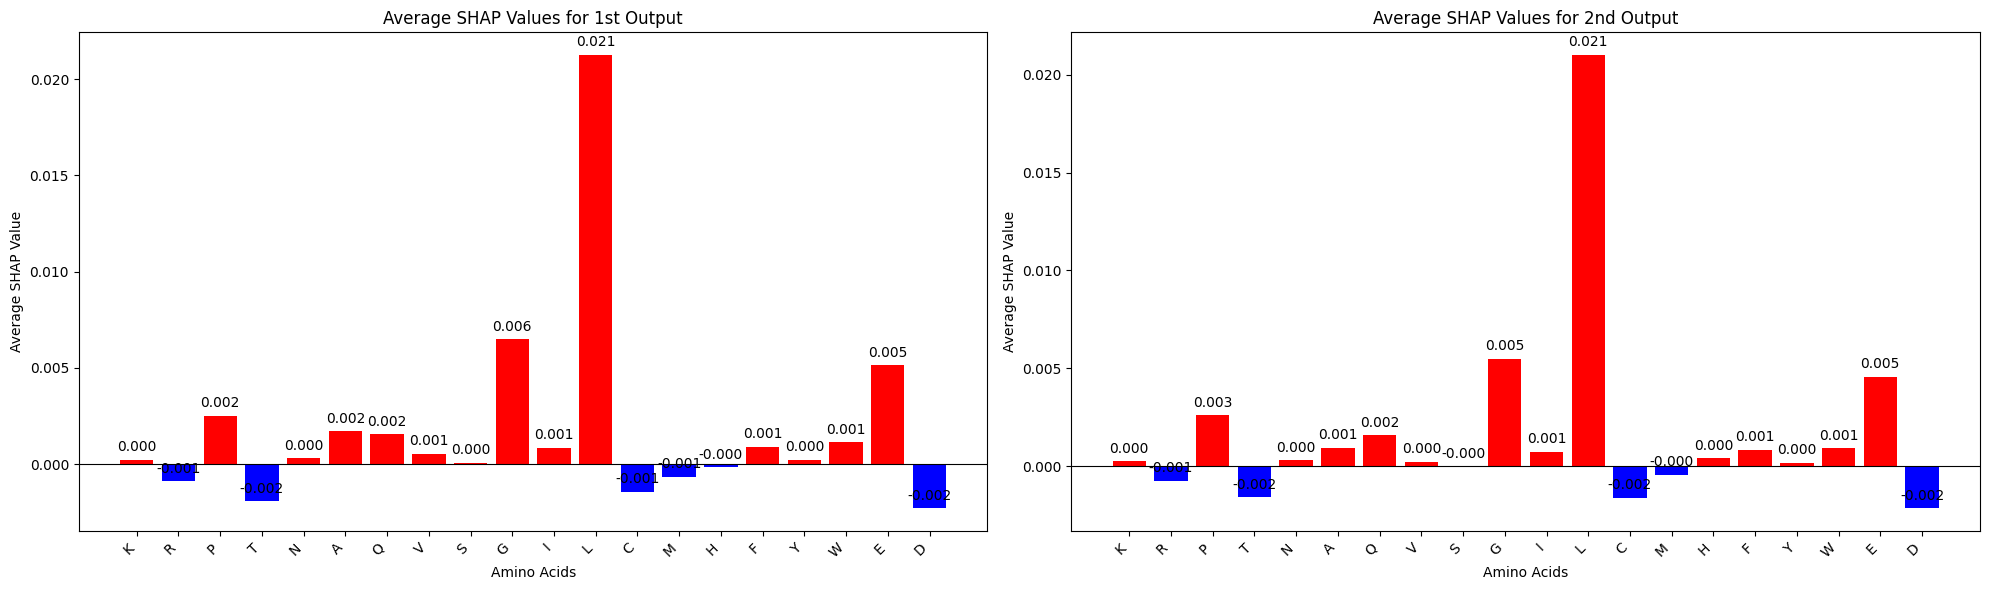

In [87]:
def plot_amino_acids_shap(amino_acids, values, title, ax):
    # Colors based on the value
    colors = ['red' if x > 0 else 'blue' for x in values]

    # Create the bar plot for the given amino acid SHAP values
    bars = ax.bar(amino_acids, values, color=colors)
    ax.set_title(title)
    ax.set_ylabel('Average SHAP Value')
    ax.set_xlabel('Amino Acids')
    ax.set_xticklabels(amino_acids, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=0.8)  # Add a line at zero for reference

    # Annotate bars with the SHAP values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Setup plots
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

# Generate bar plots
plot_amino_acids_shap(amino_acids, amino_acids_mean1, 'Average SHAP Values for 1st Output', axs[0])
plot_amino_acids_shap(amino_acids, amino_acids_mean2, 'Average SHAP Values for 2nd Output', axs[1])

plt.tight_layout()
plt.show()


# SHAP analysis for specific predictions

In [88]:
e = shap.DeepExplainer(best_model, background_tensor)

In [89]:
e.expected_value

array([516.8618 , 487.05734], dtype=float32)

In [90]:
# Get data tensor for one sample
sample = next(iter(test_loader))
sample_tensor = [t[0].unsqueeze(0).to(device) for t in sample[:-1]]
# Sample_tensor[0] is now size 60, 6, should be 1, 60, 6

In [91]:
# Calculate SHAP values for one sample
shap_values = e.shap_values(sample_tensor, check_additivity=False)

/home/robbe/.pyenv/versions/3.10.13/envs/multioutput/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [92]:
import numpy as np

# Assuming shap_values is a list of arrays, each representing a different output and containing matrices for SHAP values
# Each output matrix has a format where the last dimension is the number of predictions; we're interested in the first prediction for each output

# Extract the matrices corresponding to the first prediction for each output
shap_values_outputs = [shap_values[i][..., 1] for i in range(4)]

# Sum all values in each matrix and print them
total_shap_sums = [np.sum(output) for output in shap_values_outputs]
print("Total SHAP values for each feature set:", total_shap_sums)

# Total sum
total_sum = np.sum(total_shap_sums)
print("Total sum of SHAP values for all feature sets:", total_sum)

total_explained = e.expected_value[1] + total_sum
print("Total explained:", total_explained)

Total SHAP values for each feature set: [-4.112503484357148, -0.014240190503187478, 170.00501652341336, 1.002740146490396]
Total sum of SHAP values for all feature sets: 166.88101299504342
Total explained: 653.9383555243403
